# Section 0: Imports and Dataframes

In [1]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
from torchviz import make_dot
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

DEVICE = "cpu" #We don't need GPU on this one

In [2]:
ratings_df = pd.read_csv("data/ml-latest-small/ratings.csv", usecols=["userId", "movieId", "rating"])
display(ratings_df.tail(3))
print("========================================",)
print(ratings_df.info(), end="\n========================================\n")
n_users = ratings_df.userId.nunique()
n_movies = ratings_df.movieId.nunique()
print("Unique Users:", n_users, "\nUnique Movies:", n_movies)

,userId,movieId,rating
100833,610,168250,5.0
100834,610,168252,5.0
100835,610,170875,3.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB
None
Unique Users: 610 
Unique Movies: 9724


# Section 1: The `ratings_dataset` class.

The `ratings_dataset` class inherits `torch.utils.data.Dataset`. It requires at least 3 methods to operate.

- `__init()__`: Initializes the dataset. Any action of preprocessing the user sees fit can be done in here.
- `__len__()`: Simply returns the len() of the dataset
- `__getitem()__`: Returns an item from the dataset. This is a powerful tool since we can handle this function as we see fit and convert the data to any form we need. In this case, all data is converted to a tensor of type either `torch.long` or `torch.float32`.

Additionally we have implemented the methods `decode_movie()` and `decode_user()` which use `inverse_transform` from `LabelEncoder()` to convert the encoded items back to their original value.

In [3]:
class ratings_dataset(Dataset):
    def __init__(self, dataframe):
        self.user_encoder = LabelEncoder()
        self.movie_encoder = LabelEncoder()

        self.users =  self.user_encoder. fit_transform(dataframe.userId.values)
        self.movies = self.movie_encoder.fit_transform(dataframe.movieId.values)
        self.ratings = dataframe.rating

        self.len = len(self.users)

    def __len__(self):
        return self.len
    
    def decode_movie(self, encoded_movie:int):
        return self.movie_encoder.inverse_transform([encoded_movie])
        
    def decode_user(self, encoded_user:int):
        return self.user_encoder.inverse_transform([encoded_user])

    def __getitem__(self, index):
        u = self.users[index]
        m = self.movies[index]
        r = self.ratings[index]

        u = torch.tensor(u, device=DEVICE, dtype=torch.long)
        m = torch.tensor(m, device=DEVICE, dtype=torch.long)
        r = torch.tensor(r, device=DEVICE, dtype=torch.float32)
        
        return (u, m, r)

Prepare the `train` and `test` data. First use the classic `sklearn` function `train_test_split()`. Afterwards we should always use `reset_index()` in the split data, otherwise the `DataLoader` will certainly produce an `IndexError`.

In [4]:
train, test = train_test_split(ratings_df, train_size=0.8, shuffle=True, random_state=42)
train.reset_index(inplace=True)
test.reset_index(inplace=True)
train = ratings_dataset(train)
test = ratings_dataset(test)

BATCH_SIZE = 256

ratings_train_loader = DataLoader(dataset=train, shuffle=True, batch_size=BATCH_SIZE)
ratings_test_loader = DataLoader(dataset=test, shuffle=True, batch_size=BATCH_SIZE)

# Section 2: The `rating_prediction_nn` class.

The neural network class inherits the `nn.Module` as per `PyTorch` documentation. Here we create two different embeddings, one for users `user_embedding` and one for movies `movie_embedding`, aiming to capture the latent factors. Finally we feed the stacked output of the embeddings into the linear layer `l1` and get the final prediction for the rating.

In [5]:
class rating_prediction_nn(nn.Module):
    def __init__(self, n_users, n_movies, embedding_size):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_size)
        self.movie_embedding = nn.Embedding(n_movies, embedding_size)
        self.l1 = nn.Linear(embedding_size * 2, 64)
        self.l2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

        self.user_embedding.weight.data.uniform_(-0.5, 0.5)
        self.movie_embedding.weight.data.uniform_(-0.5, 0.5)
        self.l1.weight.data.uniform_(-0.5, 0.5)
        self.l2.weight.data.uniform_(-0.5, 0.5)

    def forward(self, user_vec, movie_vec):
        user_embeds = self.user_embedding(user_vec)
        movie_embeds = self.movie_embedding(movie_vec)

        output = torch.cat([user_embeds, movie_embeds], dim=1)

        output = self.dropout(self.l1(output))
        output = self.sigmoid(output)
        output = self.l2(output)

        return output

EMBEDDING_SIZE = 32
model = rating_prediction_nn(n_users, n_movies, EMBEDDING_SIZE).to(DEVICE)


### Make a small visualization. This requires graphviz to be installed and in PATH.

In [6]:
# user_vec = torch.randint(0, n_users, (1,))
# movie_vec = torch.randint(0, n_movies, (1,))
# output = model(user_vec, movie_vec)
# dot = make_dot(output, params=dict(model.named_parameters()))

# # Save the dot object as a png image
# dot.format = 'png'
# dot.render('torch_model')

### Train the model. 2-5 epochs are sufficient.

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()

EPOCHS = 5
N_BATCHES = len(ratings_train_loader)
losses = list()

'''
model(...) returns a `train_data` tuple.
train_data[0]: Movie tensor
train_data[1]: User tensor
train_data[2]: Rating tensor
'''
for epoch in range(EPOCHS):
    for batch, train_data in enumerate(ratings_train_loader):
        output = model(train_data[0], train_data[1])
        
        loss = loss_func(output, train_data[2].view(-1, 1))
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print(f"Epoch {epoch+1} of {EPOCHS} | Batch {batch:>3} of {N_BATCHES} | MSELoss: {loss}")


#Save model
model_info = {
    "emb_size": EMBEDDING_SIZE,
    "model_state_dict": model.state_dict(),
    "description": "Trained on 2 embeddings with 2 linear layers."
}
torch.save(model_info, "rating_prediction_torch.nn")

Epoch 1 of 5 | Batch   0 of 316 | MSELoss: 33.878684997558594
Epoch 1 of 5 | Batch 100 of 316 | MSELoss: 5.519100189208984
Epoch 1 of 5 | Batch 200 of 316 | MSELoss: 1.3896796703338623
Epoch 1 of 5 | Batch 300 of 316 | MSELoss: 1.0672070980072021
Epoch 2 of 5 | Batch   0 of 316 | MSELoss: 1.2552586793899536
Epoch 2 of 5 | Batch 100 of 316 | MSELoss: 0.8806842565536499
Epoch 2 of 5 | Batch 200 of 316 | MSELoss: 0.9622584581375122
Epoch 2 of 5 | Batch 300 of 316 | MSELoss: 0.9001598358154297
Epoch 3 of 5 | Batch   0 of 316 | MSELoss: 0.8053303956985474
Epoch 3 of 5 | Batch 100 of 316 | MSELoss: 0.9282444715499878
Epoch 3 of 5 | Batch 200 of 316 | MSELoss: 0.8976771831512451
Epoch 3 of 5 | Batch 300 of 316 | MSELoss: 0.7487978935241699
Epoch 4 of 5 | Batch   0 of 316 | MSELoss: 0.8923165798187256
Epoch 4 of 5 | Batch 100 of 316 | MSELoss: 0.7980830073356628
Epoch 4 of 5 | Batch 200 of 316 | MSELoss: 0.8526021242141724
Epoch 4 of 5 | Batch 300 of 316 | MSELoss: 0.7464991807937622
Epoch 5 o

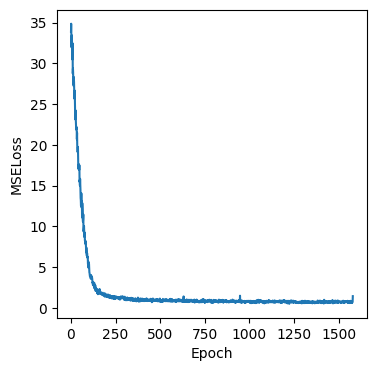

In [8]:
plt.figure(figsize=(4,4))
plt.xlabel("Epoch")
plt.ylabel("MSELoss")
plt.plot(losses)

# Section 3: RMSE Evaluation

In [9]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = list()
y_true = list()

model.eval()
with torch.no_grad():
    for i, test_data in enumerate(ratings_test_loader): 
        model_output = model(test_data[0], test_data[1])
        y_pred.append(model_output.sum().item() / len(test_data[0]))

        target_rating = test_data[2]
        y_true.append(target_rating.sum().item() / len(test_data[0]))

rmse = mean_squared_error(y_true, y_pred, squared=False)
mse = mean_squared_error(y_true, y_pred, squared=True)
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")


RMSE: 0.13046248836844704
MSE: 0.017020460871287175
MAE: 0.11215089665183538


# Section 4: Make new dataset with predicted values.

In this cell we have defined two function that predict the rating of a user-movie pair. First we use the `decode_user()` and `decode_movie()` functions to convert the encoded user and movie values to their original ones. Then extract the value from the rating tensor. Finally predict from the model without backpropagation.

The only reason there are two functions is because there are two versions of `decode_user()` and `decode_movie()` pairs, once pair present in the training dataset and the other in the testing dataset. This is done for simplicity.

In [10]:
def predict_rating_train(item:tuple[torch.tensor], verbose=False):

    '''
    item[0]: Movie tensor
    item[1]: User tensor
    item[2]: Rating tensor
    '''

    decoded_user = train.decode_user(item[0])
    decoded_movie = train.decode_movie(item[1])
    
    item[0].unsqueeze_(dim=0)
    item[1].unsqueeze_(dim=0)
    rating = item[2].item()

    y_pred = model(item[0], item[1])
    
    if verbose:
        print(f"Predicted rating of user {decoded_user} on movie {decoded_movie}: {y_pred.item():.2f}")
        print(f"Actual value: {rating}")

    return y_pred.item()

def predict_rating_test(item:dict[torch.tensor], verbose=False):

    decoded_user = test.decode_user(item[0])
    decoded_movie = test.decode_movie(item[1])
    
    item[0].unsqueeze_(dim=0)
    item[1].unsqueeze_(dim=0)
    rating = item[2].item()

    y_pred = model(item[0], item[1])
    
    if verbose:
        print(f"Predicted rating of user {decoded_user} on movie {decoded_movie}: {y_pred.item():.2f}")
        print(f"Actual value: {rating}")

    return y_pred.item()

Append the predicted ratings on new dataframes and save the dataframes on a new finalized dataframe that contains predictions.

In [11]:
# This should take 1 minute

ratings_train_df_new, ratings_test_df_new = train_test_split(ratings_df, train_size=0.8, shuffle=True, random_state=42)

train_predicted = list()
test_predicted = list()
model.eval()
with torch.no_grad():
    for i in range(len(ratings_train_df_new)):
        train_predicted.append(predict_rating_train(train[i]))
    for i in range(len(ratings_test_df_new)):
        test_predicted.append(predict_rating_test(test[i]))

In [12]:
ratings_train_df_new["predicted"] = train_predicted

In [13]:
ratings_test_df_new["predicted"] = test_predicted

In [14]:
pd.concat([ratings_train_df_new, ratings_test_df_new]).to_csv("data/ml-latest-small/new_ratings_df.csv", index=False)

# Section 5: Recommend

### Load dataframes

In [15]:
movies_df = pd.read_csv("data/ml-latest-small/movies.csv")
final_ratings_df = pd.read_csv("data/ml-latest-small/new_ratings_df.csv")
final_ratings_df.head(1)

,userId,movieId,rating,predicted
0,509,7347,3.0,3.155457


In [16]:
movies_df.head(1)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


### `recommend_movies`
Make predictions for user `userId` on the new dataframe. First keep the `movieId` from the `new_ratings_df` sorted by `predicted`. Then find the movie titles that are in the `top_n_movies`.

In [17]:
def recommend_movies(df, userId, n_values=5):
    top_n_movies = df[df.userId == userId].sort_values(by="predicted", ascending=False).head(n_values)[["movieId"]]
    top_n_movies = movies_df[movies_df["movieId"].isin(top_n_movies["movieId"])]
    return top_n_movies[["title", "genres"]]

### Make predictions for user 2.

These recommendations look pretty reasonable. We can observe both here and in the clusters that the top recommended movies have
mostly the same genres. This model is more powerful compared to `02` in the sense that we not only get movies that contain the title, but movies that are *close* to the user's preferences since we exploit the latent factors. 

In [18]:
recommend_movies(final_ratings_df, 1, 10)

,title,genres
46,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
224,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
257,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
828,Reservoir Dogs (1992),Crime|Mystery|Thriller
863,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
898,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
899,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
909,Apocalypse Now (1979),Action|Drama|War
914,Goodfellas (1990),Crime|Drama
2226,Fight Club (1999),Action|Crime|Drama|Thriller


### Make predictions for user 600

In [19]:
recommend_movies(final_ratings_df, 600, 10)

,title,genres
659,"Godfather, The (1972)",Crime|Drama
694,Casablanca (1942),Drama|Romance
889,"Sex, Lies, and Videotape (1989)",Drama
901,Brazil (1985),Fantasy|Sci-Fi
914,Goodfellas (1990),Crime|Drama
1231,Chasing Amy (1997),Comedy|Drama|Romance
1711,"Producers, The (1968)",Comedy
2226,Fight Club (1999),Action|Crime|Drama|Thriller
3197,Pearl Harbor (2001),Action|Drama|Romance|War
4909,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi
